In [1]:
### This notebook is run by R kernel.
### Please run IRkernel::installspec() on your R terminal

In [2]:
### Import required libraries ###
# FYI: this notebook requires {igraph} & {dplyr}
library(igraph)
library(dplyr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Read CSV
d <- read.csv('user_journey_sample.csv')
d$id <- as.character(d$id)
d$touch <- as.character(d$touch)

In [4]:
#################
# Preprocessing #
#################

# Empty graph data frame to store the graph dataset
dg <- c()

# Many if-clause to transform a sequence to markov chains
for (i in 1:nrow(d)){
  # Top with only 1 touch point
  if (i == 1 && d$id[i] == d$id[i + 1] &&
      d$id[i] != d$id[i + 1]){
    dg <- c(d$id[i], 'start', d$touch[i])
    dg <- rbind(dg, c(d$id[i], d$touch[i], 'end'))
  }
  # Top with more than 1 touch point
  if (i == 1 && d$id[i] == d$id[i + 1] &&
      d$id[i] == d$id[i + 1]){
    dg <- c(d$id[i], 'start', d$touch[i])
  }
  # Not last, only 1 touch point
  if (i > 1 && i != nrow(d) && d$id[i] != d$id[i - 1]
      && d$id[i] != d$id[i + 1]){
    dg <- rbind(dg, c(d$id[i], 'start', d$touch[i]))
    dg <- rbind(dg, c(d$id[i], d$touch[i], 'end'))
  }
  # Not last, More than 1 touch point
  ## Top
  if (i > 1 && i != nrow(d) && d$id[i] != d$id[i - 1]
      && d$id[i] == d$id[i + 1]){
    dg <- rbind(dg, c(d$id[i], 'start', d$touch[i]))
  }
  ## Middle
  if (i > 1 && i != nrow(d) && d$id[i] == d$id[i - 1]
      && d$id[i] == d$id[i + 1]){
    dg <- rbind(dg, c(d$id[i], d$touch[i - 1], d$touch[i]))
  }
  ## Last
  if (i > 1 && i != nrow(d) && d$id[i] == d$id[i - 1]
      && d$id[i] != d$id[i + 1]){
    dg <- rbind(dg, c(d$id[i], d$touch[i - 1], d$touch[i]))
    dg <- rbind(dg, c(d$id[i], d$touch[i], 'end'))
  }
  # Last with more than 1 touch point
  if (i == nrow(d) && d$id[i] == d$id[i - 1]){
    dg <- rbind(dg, c(d$id[i], d$touch[i - 1], d$touch[i]))
    dg <- rbind(dg, c(d$id[i], d$touch[i], 'end'))
  }
  # Last with only 1 touch point
  if (i == nrow(d) && d$id[i] != d$id[i - 1]){
    dg <- rbind(dg, c(d$id[i], 'start', d$touch[i]))
    dg <- rbind(dg, c(d$id[i], d$touch[i], 'end'))
  }
}

# Store the markov chains into the data frame
dg1 <- data.frame(id = dg[, 1],
                  before = dg[, 2], after = dg[, 3],
                  num = 1)


In [5]:
####################
# Compute "weight" #
####################

df <- dg1 %>%
  group_by(before, after) %>%
  summarise(weight = sum(num)) %>%
  as.data.frame()


`summarise()` regrouping output by 'before' (override with `.groups` argument)


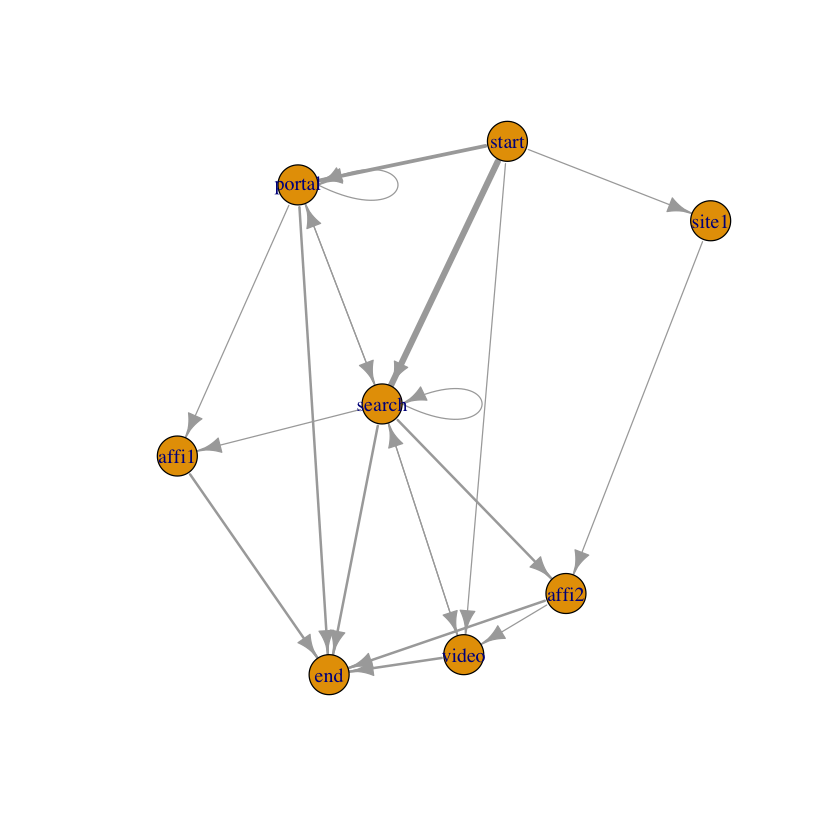

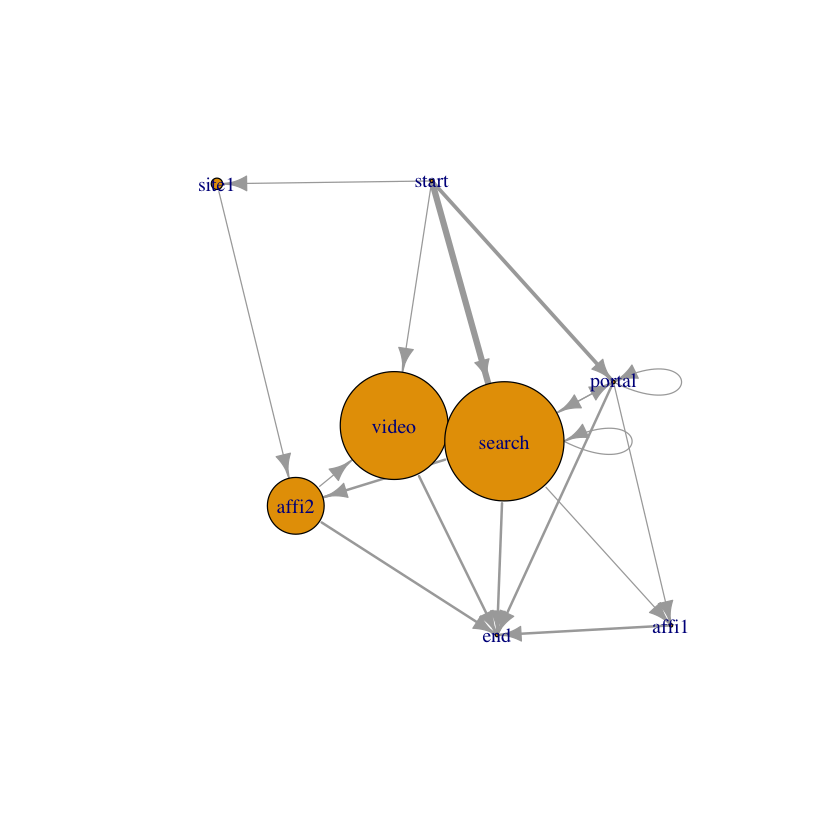

In [6]:
####################################################
# Compose the graph and estimate centrality values #
####################################################

# Create the graph
g <- graph.edgelist(as.matrix(df[, -3]), directed = T)
E(g)$value <- df$weight

# Plot
plot(g, edge.width = E(g)$value, layout = layout_with_fr)

# Estimate betweenness centrality
V(g)$value <- betweenness(g, v = V(g), directed = T,
                          weights = E(g)$value)

# Plot with betweenness centrality
plot(g, edge.width = E(g)$value, vertex.size = V(g)$value * 5,
     layout = layout_with_fr)

